# Import Library

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import zipfile
import shutil
from keras import utils, callbacks
import os
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import matplotlib.pyplot
from keras.applications.vgg16 import VGG16
from keras.layers import Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy


In [28]:
# dataset_zip = zipfile.ZipFile('dataku.zip')
# dataset_zip.extractall()
# dataset_zip.close()

# **Spiliting Dataset**

In [130]:
from tensorflow.python import training
training_dir= os.path.join('dataset', 'data-train', )
validation_dir= 'validation'

In [131]:
os.mkdir(validation_dir)

In [132]:
validation_dataset_portion= 0.10

In [133]:
for class_dir_name in os.listdir(training_dir):
  # class_dir_name -> nama file nya doang -> A B C
  # print(class_dir_name)
  # asl_alphabet_train/asl_alphabet_train/A
    class_dir_path = os.path.join(training_dir, class_dir_name)

  # cari banyak data training dari tiap kelas
    train_dataset_num = len(os.listdir(class_dir_path)) # 3000

  # cari banyak data validation -> 1 persen dari data training
    val_dataset_num = validation_dataset_portion * train_dataset_num # 30

  # buat direktori kelas di direktori validation
  # validation/A
    val_class_dir_path = os.path.join(validation_dir, class_dir_name)
    os.mkdir(val_class_dir_path)

  # perlu variabel counter untk ngitung berapa banyak foto yang udah dipindah dari training->validation
    counter = 0

    for filename in os.listdir(class_dir_path) :
        
    # filename -> A1.JPG
    # filepath -> asl_alphabet_train/asl_alphabet_train/A/A1.JPG
        filepath = os.path.join(class_dir_path, filename)

        if counter < val_dataset_num:
      # move(source, destination)
      # source -> asl_alphabet_train/asl_alphabet_train/A/A1.JPG
      # dest -> validation/A/A1.JPG
            destination = os.path.join(val_class_dir_path, filename)
            shutil.move(filepath, destination)
            counter += 1

In [148]:
from tensorflow.python import training
training_dir= os.path.join('dataset', 'data-train', )
validation_dir = os.path.join('validation')

# Image Data Generator

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image

# Define the folder path containing your images
folder_path = "dataset/data-train/Mengantuk & Menguap"

# Get a list of filenames in the folder
filenames = os.listdir(folder_path)

# Function to perform image augmentation
def augment_image(image):
    # Rotations
    rotated_90 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    #rotated_180 = cv2.rotate(image, cv2.ROTATE_180)
    #rotated_270 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)

    # Flips
    flipped_horizontal = cv2.flip(image, 1)
    #flipped_vertical = cv2.flip(image, 0)

    # Grayscale conversion
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # HSV conversion
    #hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # # HSV adjustments
    # hue_shifted = hsv.copy()
    # hue_shifted[:, :, 0] = (hue_shifted[:, :, 0] + 30) % 180
    # saturation_shifted = hsv.copy()
    # saturation_shifted[:, :, 1] = np.clip(saturation_shifted[:, :, 1] * 1.2, 0, 255)
    # value_shifted = hsv.copy()
    # value_shifted[:, :, 2] = np.clip(value_shifted[:, :, 2] * 1.2, 0, 255)

    # Zooming and shearing
    zoomed = cv2.resize(image, (int(image.shape[1] * 1.2), int(image.shape[0] * 1.2)))
    sheared = cv2.warpAffine(image, np.array([[1, 0.2, 0], [0, 1, 0]]), (image.shape[1], image.shape[0]))

    # Width and height shifts (optional)
    # Implement these if you want to add horizontal and vertical shifts
    # width_shifted = cv2.translate(image, (int(image.shape[1] * 0.2), 0))
    # height_shifted = cv2.translate(image, (0, int(image.shape[0] * 0.2)))

    # Combine augmented images
    
        # Combine augmented images
    augmented_images = [
        rotated_90,
        flipped_horizontal,
        zoomed, sheared,
        # width_shifted, height_shifted  # Add these if needed
    ]
    # augmented_images = [
    #     rotated_90, rotated_180, rotated_270,
    #     flipped_horizontal, flipped_vertical,
    #     grayscale, hsv, hue_shifted, saturation_shifted, value_shifted,
    #     zoomed, sheared,
    #     # width_shifted, height_shifted  # Add these if needed
    # ]

    return augmented_images

# Process each image in the folder
for filename in filenames:
    # Read the image
    image = cv2.imread(os.path.join(folder_path, filename))

    # Perform augmentation
    augmented_images = augment_image(image)

    # Save augmented images with appropriate naming
    for i, augmented_image in enumerate(augmented_images):
        new_filename = f"{filename[:-4]}_{i+1}.jpg"  # Maintain original filename format
        cv2.imwrite(os.path.join(folder_path, new_filename), augmented_image)

print("Image augmentation completed!")


In [149]:
training = ImageDataGenerator (
    rescale = 1./255,
    horizontal_flip = True,
    validation_split= 0.1,
    shear_range = 0.2,
    zoom_range = 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2
)

validation = ImageDataGenerator (
    rescale = 1./255,
    validation_split= 0.1,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    width_shift_range = 0.2,
    height_shift_range = 0.2

)

In [150]:
training_generator = training.flow_from_directory (
    training_dir,
    target_size = (64, 64),
    batch_size = 256,
    class_mode = 'categorical',
    shuffle = True,
)

validation_generator = validation.flow_from_directory (
    validation_dir,
    target_size = (64, 64),
    batch_size = 256,
    class_mode = 'categorical',
    shuffle = True
)

Found 8050 images belonging to 3 classes.
Found 895 images belonging to 3 classes.


In [151]:
# Learn about dataset labels

dataset_labels = sorted(training_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Mengantuk & Menguap' 'Mengantuk Tidak Menguap'
 'Tidak Mengantuk & Menguap']


In [152]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,  MaxPooling2D,  Activation, Dense, Flatten, Dropout


model = Sequential()

model.add(Conv2D(64, (3, 3), input_shape = (64,64,3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(64, activation = 'relu'))
model.add(Dense(3, activation = 'softmax'))

In [153]:
model.compile (
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'],
    optimizer = Adam(learning_rate=0.001)
)

#model.summary()

In [154]:
earlystopping = callbacks.EarlyStopping(monitor="val_loss", 
                                        mode="min",
                                        patience=5, 
                                        restore_best_weights = True)

In [155]:
history = model.fit(training_generator,
                    validation_data = validation_generator,
                    epochs = 30,
                    shuffle = True,
                    verbose = 1,
                    callbacks = [earlystopping])

Epoch 1/30
32/32 [==============================] - 694s 21s/step - loss: 1.0905 - accuracy: 0.3681 - val_loss: 1.0486 - val_accuracy: 0.3832
Epoch 2/30
32/32 [==============================] - 682s 21s/step - loss: 1.0473 - accuracy: 0.4381 - val_loss: 1.0542 - val_accuracy: 0.3888
Epoch 3/30
32/32 [==============================] - 678s 21s/step - loss: 0.9995 - accuracy: 0.4734 - val_loss: 1.0288 - val_accuracy: 0.3989
Epoch 4/30
32/32 [==============================] - 687s 21s/step - loss: 0.9537 - accuracy: 0.5094 - val_loss: 0.9570 - val_accuracy: 0.4939
Epoch 5/30
32/32 [==============================] - 688s 21s/step - loss: 0.9208 - accuracy: 0.5379 - val_loss: 0.9839 - val_accuracy: 0.5084
Epoch 6/30
32/32 [==============================] - 674s 21s/step - loss: 0.8760 - accuracy: 0.5634 - val_loss: 0.9042 - val_accuracy: 0.5296
Epoch 7/30
32/32 [==============================] - 699s 22s/step - loss: 0.8502 - accuracy: 0.5860 - val_loss: 0.8627 - val_accuracy: 0.5788
Epoch 

# Evaluate model on test set( Generator Version)

In [156]:
final_loss, final_accuracy = model.evaluate(validation_generator)

4/4 [==============================] - 27s 5s/step - loss: 0.6442 - accuracy: 0.7676


In [157]:
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

Final accuracy: 76.76%


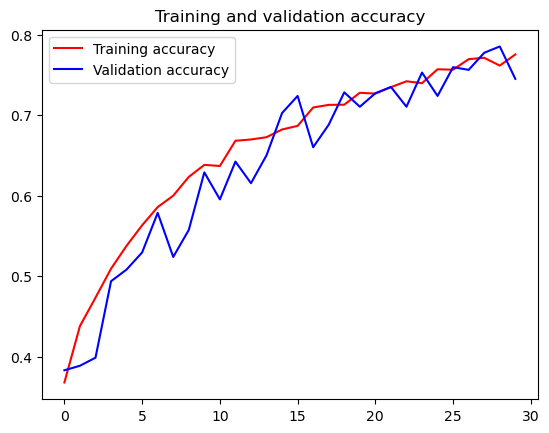

<Figure size 640x480 with 0 Axes>

In [158]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

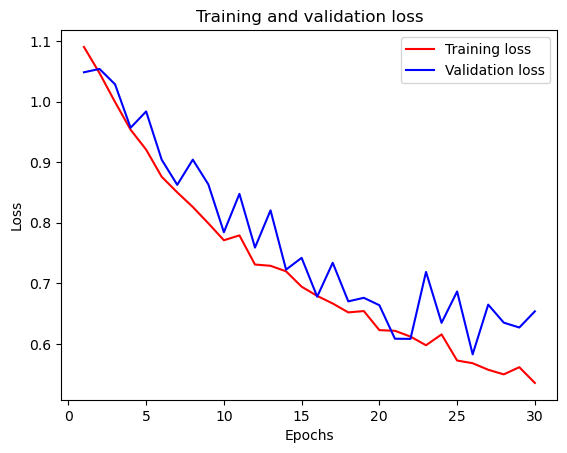

In [159]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Found 995 images belonging to 3 classes.
16/16 [==============================] - 30s 2s/step
Confusion Matrix:
[[154  58 143]
 [ 94 146  80]
 [ 93  39 188]]

Classification Report:
                           precision    recall  f1-score   support

      Mengantuk & Menguap       0.45      0.43      0.44       355
  Mengantuk tidak Menguap       0.60      0.46      0.52       320
Tidak Mengantuk & Menguap       0.46      0.59      0.51       320

                 accuracy                           0.49       995
                macro avg       0.50      0.49      0.49       995
             weighted avg       0.50      0.49      0.49       995



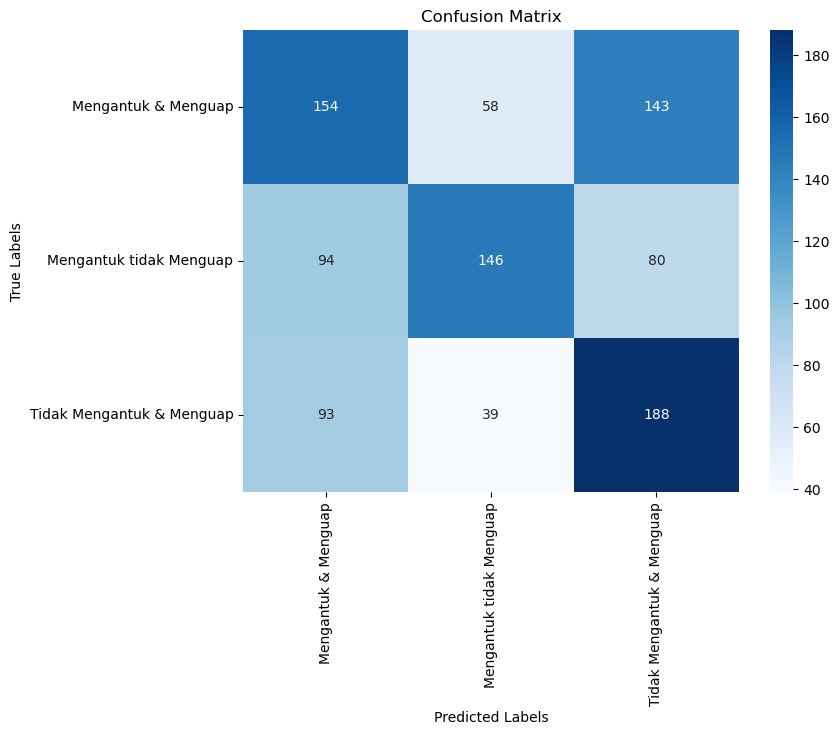

In [161]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
# Misalkan Anda memiliki model CNN yang sudah dilatih
# model = ...

# Buat generator data uji menggunakan ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)  # Normalisasi nilai piksel
test_generator = test_datagen.flow_from_directory(
    'dataset\data-test',  # Direktori data uji
    target_size=(64, 64),  # Ukuran gambar yang diharapkan
    batch_size=64,
    class_mode='categorical',  # Mode kelas untuk klasifikasi multikelas
    shuffle=False  # Tetapkan False agar urutan data tidak diacak
)

# Prediksi kelas untuk data uji
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1) # Ambil kelas dengan probabilitas tertinggi

# Ambil label yang sebenarnya dari data uji
y_true = test_generator.classes

# Hitung confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Tampilkan confusion matrix
print("Confusion Matrix:")
print(cm)

# Tampilkan laporan klasifikasi
class_labels = list(test_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names= class_labels))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


## **Saved and Load Model**

In [171]:
model.save('models/cnnCat2.h5', overwrite=True)

C:\Users\Alfianri Manihuruk\miniconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [172]:
ASL_SAVED_MODEL = "saved_models/asl1"
tf.saved_model.save(model, ASL_SAVED_MODEL)

INFO:tensorflow:Assets written to: saved_models/asl1\assets


INFO:tensorflow:Assets written to: saved_models/asl1\assets


In [173]:
# Load the SavedModel
import tensorflow_hub as hub
asl_model = hub.load(ASL_SAVED_MODEL)
print(asl_model)


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x000001704A65EBE0>


In [174]:
# Get images and labels batch from validation dataset generator

val_image_batch, val_label_batch = next(iter(validation_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)

print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (256, 64, 64, 3)


In [175]:
tf_model_predictions = asl_model(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

Prediction results shape: (256, 3)


In [176]:
# Convert prediction results to Pandas dataframe, for better visualization

tf_pred_dataframe = pd.DataFrame(tf_model_predictions.numpy())
tf_pred_dataframe.columns = dataset_labels

print("Prediction results for the first elements")
tf_pred_dataframe.head()

Prediction results for the first elements


,Mengantuk & Menguap,Mengantuk Tidak Menguap,Tidak Mengantuk & Menguap
0,0.325544,0.198150,0.476306
1,0.704934,0.268124,0.026942
2,0.086487,0.814539,0.098975
3,0.710547,0.108475,0.180978
4,0.094389,0.591007,0.314604


In [177]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]

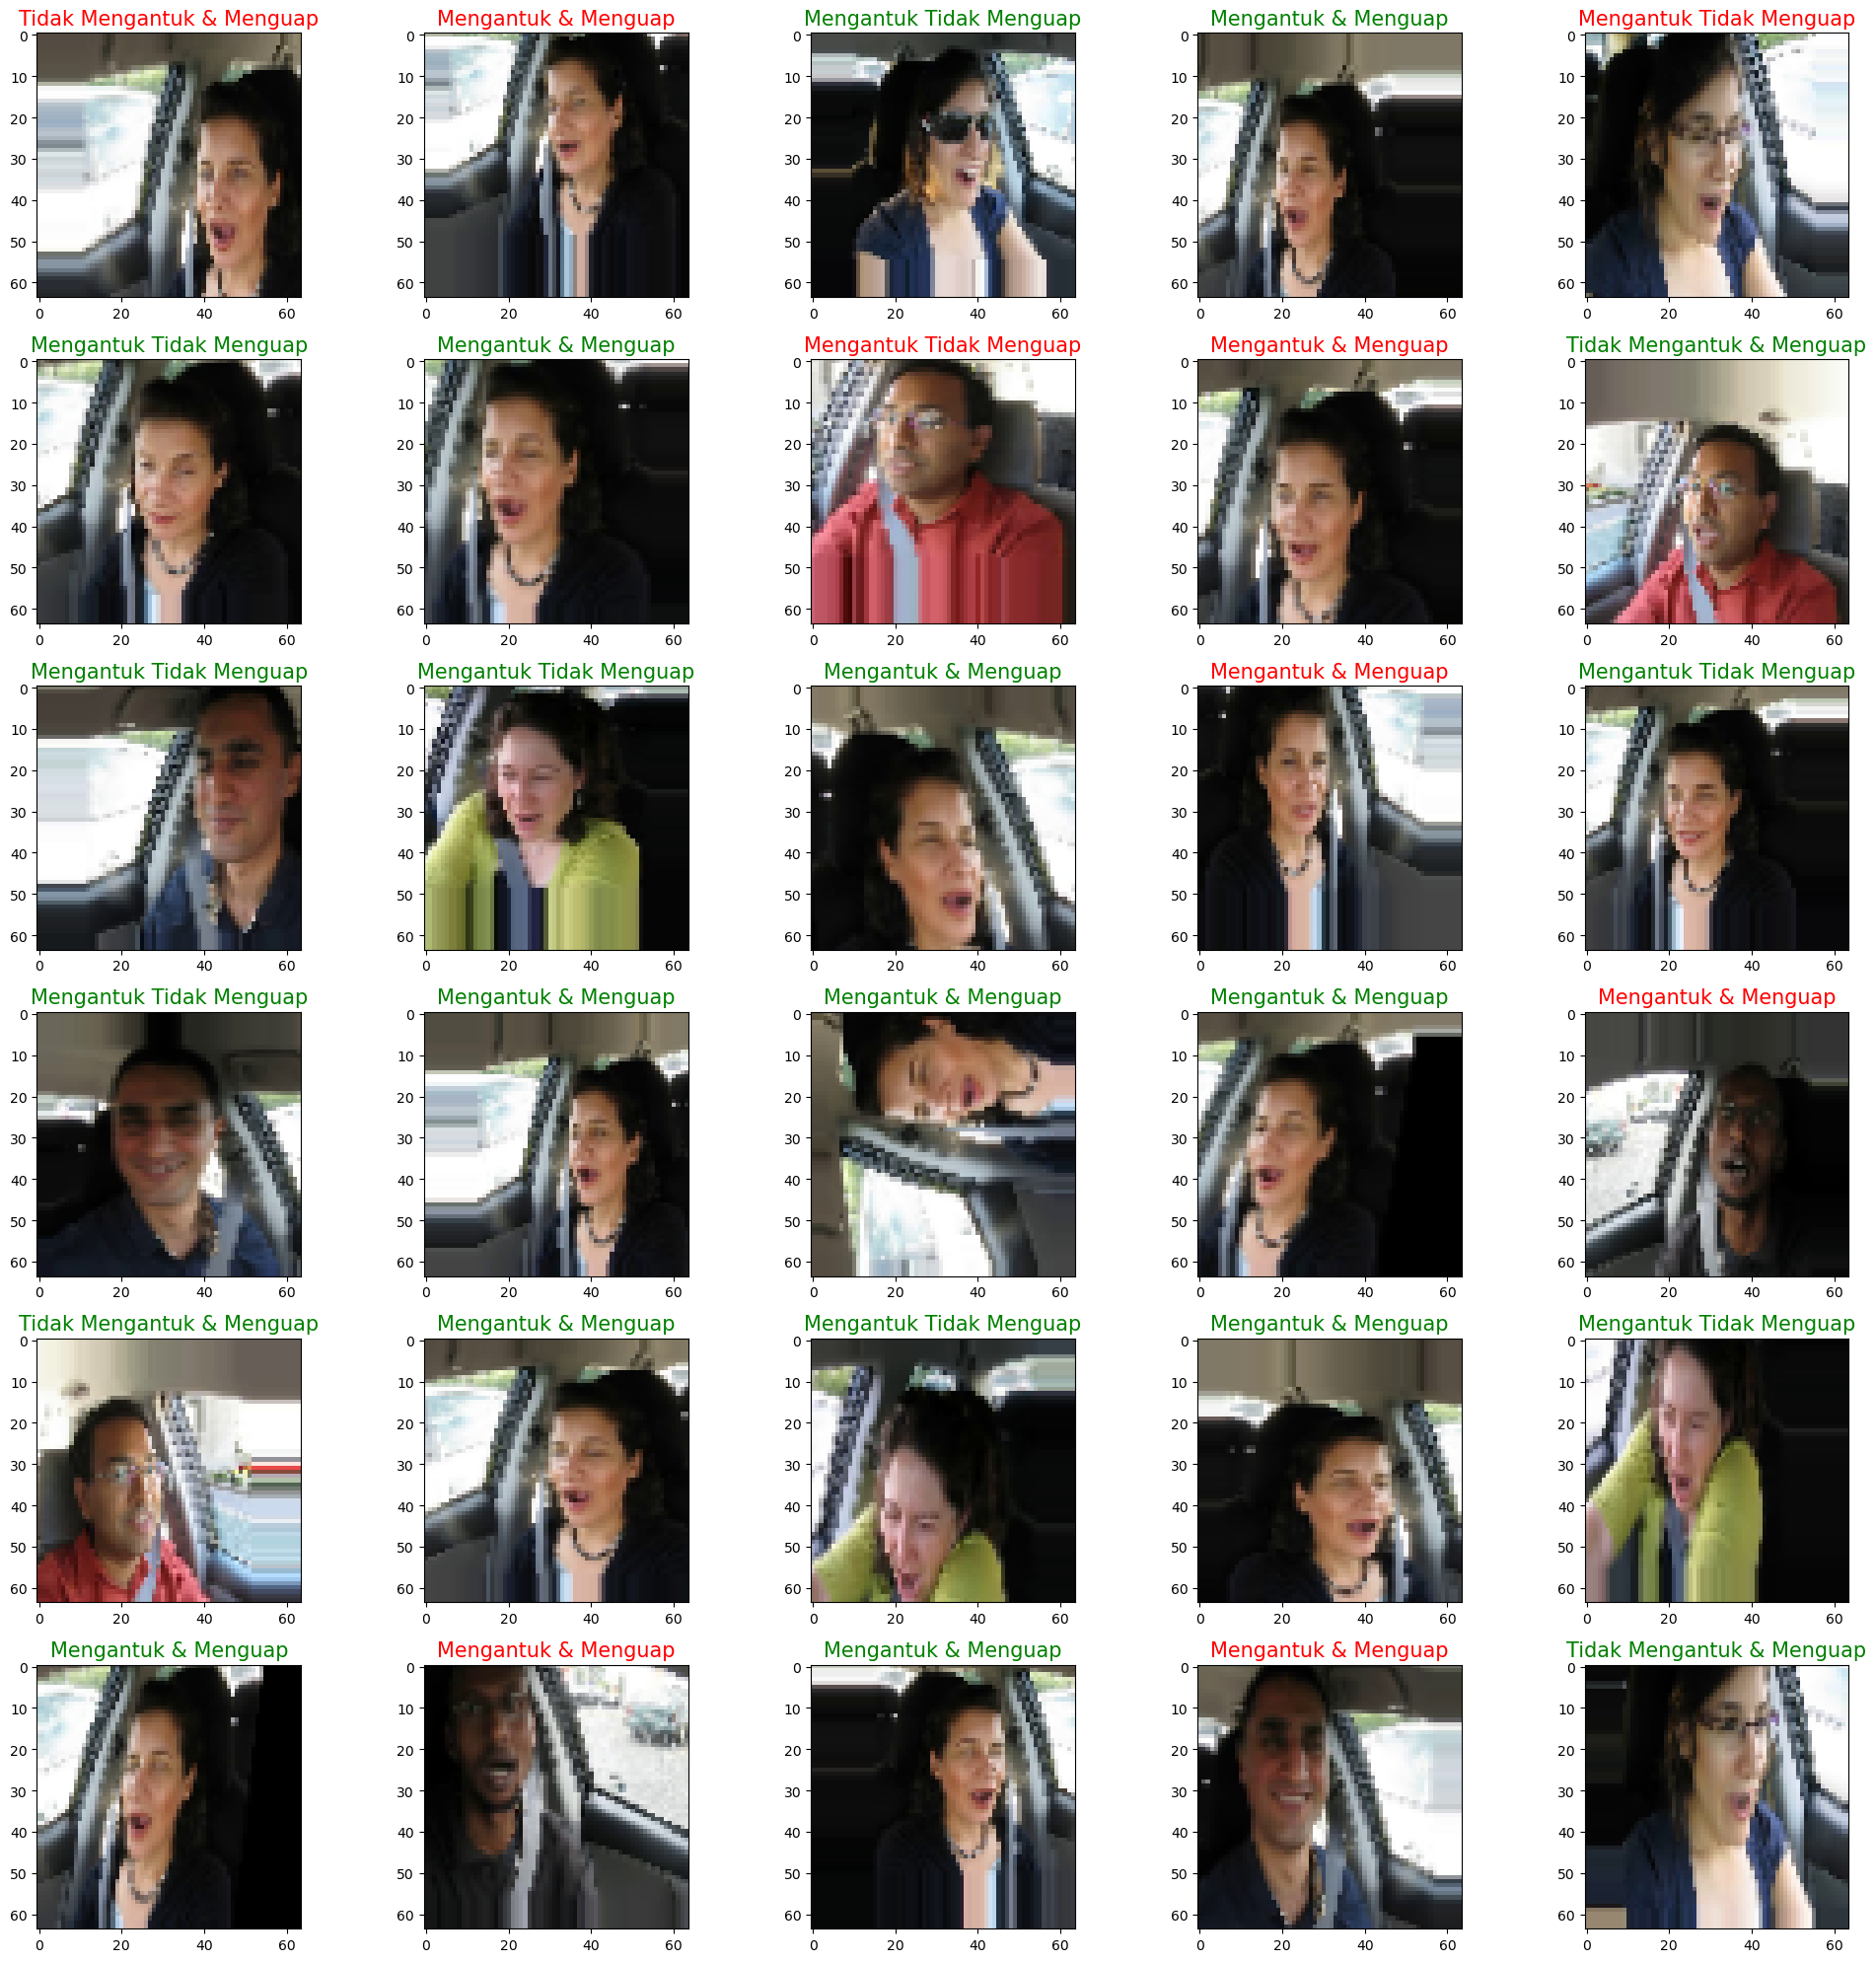

In [189]:
import matplotlib.pyplot as plt

# Membuat gambar subplot lebih besar
plt.figure(figsize=(20, 20))

# Ubah iterasi for untuk memastikan hanya menggunakan indeks yang valid
for n in range(min(30, len(val_image_batch))):  # Gunakan jumlah elemen dalam val_image_batch atau maksimal 30
    plt.subplot(6, 5, n+1)  # Ubah ukuran subplot menjadi 6 baris dan 5 kolom
    plt.imshow(val_image_batch[n])
    color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
    plt.title(predicted_labels[n].title(), color=color, fontsize=15)  # Menentukan ukuran font menjadi 10

plt.tight_layout()  # Menyesuaikan layout subplot agar sesuai
plt.show()


# Convert Model to TFLite

In [ ]:
!mkdir "tflite_models"
TFLITE_MODEL = "tflite_models/asl.tflite"
TFLITE_QUANT_MODEL = "tflite_models/asl_quant.tflite"

In [ ]:
# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : asl_model(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

# Convert the model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

# Convert the model to quantized version with post-training quantization
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_quant_model = converter.convert()
open(TFLITE_QUANT_MODEL, "wb").write(tflite_quant_model)

print("TFLite models and their sizes:")
!ls "tflite_models" -lh

TFLite models and their sizes:
total 3.7M
-rw-r--r-- 1 root root 753K Dec 28 18:42 asl_quant.tflite
-rw-r--r-- 1 root root 2.9M Dec 28 18:42 asl.tflite


In [ ]:
os.chdir("/content")
from google.colab import files
uploaded = files.upload()

KeyboardInterrupt: ignored

In [ ]:
from tensorflow.keras.preprocessing import image
def getPrediction(path):
    img = image.load_img(path, target_size=(64,64))
    imgplot = plt.imshow(img)

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    predicted = model.predict(images).squeeze()
    print(dataset_labels[np.argmax(predicted)])

In [ ]:
getPrediction("download.jpg")
